In [1]:
import geone
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pickle
from geone import imgplot3d
import pyvista as pv

sys.path.append("../../../prog/geostat/EROS/")
sys.path.append("../")
import EROS

In [2]:
def surfs_int(alt, covs, top, bot):
    
    sims = []
    for i in range(len(alt)):

        sim = geone.multiGaussian.multiGaussianRun(covs[i], nx, sx, output_mode="array", mean=alt[i])[0]
        sim[sim > top] = top[sim > top]
        sim[sim < bot] = bot[sim < bot]

        for o in range(i):  # erosion rules
            s2 = sims[o]  # older surface

            mask = s2 > sim
            s2[mask] = sim[mask]
        sims.append(sim)
    
    return sims

In [3]:
# from merge_two_covmodels import * 

In [4]:
with open("cm_params_NS.pkl", "rb") as f:
    ns = pickle.load(f)
    
with open("cm_params_EW.pkl", "rb") as f:
    ew = pickle.load(f)

In [5]:
ew[4]

*** CovModel1D object ***
name = 'cov1D-multi-contribution'
number of elementary contribution(s): 3
elementary contribution 0
    type: spherical
    parameters:
        w = 0.047233523810471016
        r = 43.5747063045942
elementary contribution 1
    type: cubic
    parameters:
        w = 0.40880454871251315
        r = 44.36080345389514
elementary contribution 2
    type: exponential
    parameters:
        w = 0.00213663722280625
        r = 41.58781461836194
*****

In [6]:
ns[3]

*** CovModel1D object ***
name = 'cov1D-multi-contribution'
number of elementary contribution(s): 2
elementary contribution 0
    type: cubic
    parameters:
        w = 0.2680875736151002
        r = 15.979741526540924
elementary contribution 1
    type: cubic
    parameters:
        w = 0.3885146722456591
        r = 29.901044125263223
*****

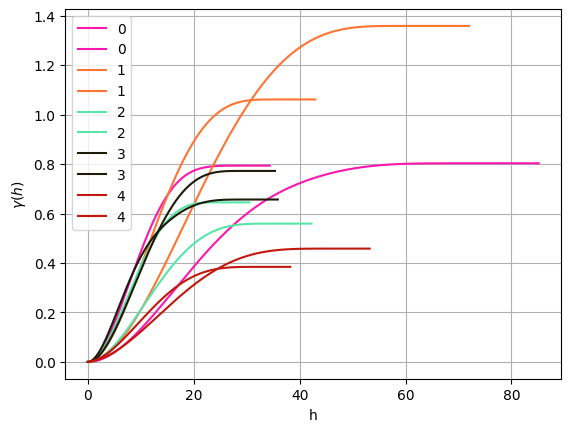

In [7]:
for i_group in range(5):
    
    color = np.random.random(3)
    ns[i_group].plot_model(1, c=color, label=i_group)
    ew[i_group].plot_model(1, c=color, label=i_group)
    
    plt.legend()

In [8]:
ns[i_group]

*** CovModel1D object ***
name = 'cov1D-multi-contribution'
number of elementary contribution(s): 3
elementary contribution 0
    type: spherical
    parameters:
        w = 0.033998096609768054
        r = 30.280577219182565
elementary contribution 1
    type: cubic
    parameters:
        w = 0.34863220117967847
        r = 31.863577222821558
elementary contribution 2
    type: exponential
    parameters:
        w = 0.00167676605583729
        r = 22.97360036812227
*****

In [9]:
def merge_covmodels(cm1, cm2):
    
    elem = []
    for cov_type in ("spherical", "cubic", "exponential", "gaussian", "nugget", "power"):

        elem_i = []
        for cm in (cm1, cm2):
            for e in cm.elem:
                if e[0] == cov_type:
                    elem_i.append(e)
                    break
        
        if len(elem_i) == 0:
            pass
        elif len(elem_i) == 1:
            ran = [elem_i[0][1]["r"], elem_i[0][1]["r"]]
            elem.append((cov_type, {"w": elem_i[0][1]["w"], "r":ran}))
        else:
            if cov_type == "nugget":
                elem.append((cov_type, {"w": (elem_i[0][1]["w"] + elem_i[1][1]["w"]) / 2}))
            else:
                elem.append((cov_type, {"w": (elem_i[0][1]["w"] + elem_i[1][1]["w"]) / 2,
                                        "r": [elem_i[0][1]["r"], elem_i[1][1]["r"]]}))
    
    cm = geone.covModel.CovModel2D(elem = elem)
    
    return cm

In [10]:
# merge covariances
cm_merged_list = []
for igroup in range(5):

    cm_ns = ns[igroup]
    cm_ew = ew[igroup]
    
    elem = []
    for cov_type in ("spherical", "cubic", "exponential", "gaussian", "nugget", "power"):

        elem_i = []
        for cm in (cm_ew, cm_ns):
            for e in cm.elem:
                if e[0] == cov_type:
                    elem_i.append(e)
                    break
        
        if len(elem_i) == 0:
            pass
        elif len(elem_i) == 1:
            ran = [elem_i[0][1]["r"], elem_i[0][1]["r"]]
            elem.append((cov_type, {"w": elem_i[0][1]["w"], "r":ran}))
        else:
            if cov_type == "nugget":
                elem.append((cov_type, {"w": (elem_i[0][1]["w"] + elem_i[1][1]["w"]) / 2}))
            else:
                elem.append((cov_type, {"w": (elem_i[0][1]["w"] + elem_i[1][1]["w"]) / 2,
                                        "r": [elem_i[0][1]["r"], elem_i[1][1]["r"]]}))
    
    cm = geone.covModel.CovModel2D(elem = elem)
    cm_merged_list.append(cm)

In [11]:
# np.random.seed(64)
# cm_merged_list = []
# for igroup in range(5):

#     cm_ns = ns[igroup]
#     cm_ew = ew[igroup]

#     cm_merged = merge_two_covmodels(cm_ns, cm_ew)
#     color = np.random.random(3)
#     cm_merged.plot_model(color=color)
#     cm_ns.plot_model(linestyle="--", color=color)
#     cm_ew.plot_model(linestyle="--", color=color)
    
#     cm_merged_list.append(cm_merged)

In [12]:
# EW

#probas
proba1 = (0.10, 0.15, 0.1, 0.70)  # blue, brown, green, yellow
proba2 = (0.08, 0, 0.12, 0.8)
proba3 = (0.05, 0, 0.22, 0.73)
proba4 = (0, 0.10, 0.5, 0.4)
proba5 = (0, 0, 0.1, 0.9)
probas_ew = [proba1, proba2, proba3, proba4, proba5]

#N
N_ew = [20, 15, 10, 10, 3]

# alts
alt_ew = [3.9, 5.75, 8.23, 10.59]

#covs
cm_r5_ew = geone.covModel.CovModel1D(elem = [("cubic", {"w":0.12, "r":25}),
                                              ("cubic", {"w":0.15, "r":60})])
cm_r4_ew = geone.covModel.CovModel1D(elem = [("cubic", {"w":0.25, "r":90})])

#NS
# probas
proba1 = (0, 0.1, 0.5, 0.4)
proba2 = (0, 0.31, 0.32, 0.37)
proba3 = (0, 0.35, 0.2, 0.45)
proba4 = (0, 0.45, 0, 0.45)
proba5 = (0, 0, 0, 1)
probas_ns = [proba1, proba2, proba3, proba4, proba5]

#N
N_ns = [10, 15, 10, 20, 3]

#covs
cm_r5_ns = geone.covModel.CovModel1D(elem = [("cubic", {"w":0.65, "r":68}),
                                              ("cubic", {"w":0.1, "r":30})])

cm_r4_ns = geone.covModel.CovModel1D(elem = [("cubic", {"w":0.26, "r":90}),
                                              ("spherical", {"w":0., "r":80})])

# alts
alt_ns = [4.43, 7.22, 10.99, 13.68]

## merge everything

#facies ids
facies_ids = [1, 2, 3, 4]

# Mean probas --> blue, brown, green, yellow
proba1 = np.array((probas_ew[0][0] + probas_ns[0][1], probas_ew[0][1] + 0, probas_ew[0][2] + \
          probas_ns[0][0], probas_ew[0][3] + probas_ns[0][2]))
proba1 /= proba1.sum()

proba2 = np.array((probas_ew[1][0] + probas_ns[1][1], probas_ew[1][1] + 0, probas_ew[1][2] + \
          probas_ns[1][0], probas_ew[1][3] + probas_ns[1][2]))
proba2 /= proba2.sum()

proba3 = np.array((probas_ew[2][0] + probas_ns[2][1], probas_ew[2][1] + 0, probas_ew[2][2] + \
          probas_ns[2][0], probas_ew[2][3] + probas_ns[2][2]))
proba3 /= proba3.sum()

proba4 = np.array((probas_ew[3][0] + probas_ns[3][1], probas_ew[3][1] + 0, probas_ew[3][2] + \
          probas_ns[3][0], probas_ew[3][3] + probas_ns[3][2]))
proba4 /= proba4.sum()

proba5 = np.array((probas_ew[4][0] + probas_ns[4][1], probas_ew[4][1] + 0, probas_ew[4][2] + \
          probas_ns[4][0], probas_ew[4][3] + probas_ns[4][2]))
proba5 /= proba5.sum()

probas = [proba1, proba2, proba3, proba4, proba5]

# colors of each facies
colors = np.array(([0.4, 0.6, 1. , 1. ], 
                  [0.6, 0.2, 0. , 1. ],
                  [0.2, 0.6, 0. , 1. ],
                  [1. , 0.8, 0.2, 1. ]))
                 
# N
N = np.mean(np.array((N_ew, N_ns)), 0)  # number of surfaces

# alts
alts = np.mean(np.array((alt_ew, alt_ns)), 0)  # number of surfaces

# covs
cm_r5 = merge_covmodels(cm_r5_ew, cm_r5_ns)
cm_r4 = merge_covmodels(cm_r4_ew, cm_r4_ns)
covs = [cm_r4, cm_r5, cm_r4, cm_r4]

### Functions

In [13]:
def surfs_int(alt, covs, top, bot, dim, spa):
    
    sims = []
    for i in range(len(alt)):

        sim = geone.multiGaussian.multiGaussianRun(covs[i], dim, spa, output_mode="array", mean=alt[i], use_multiprocessing=False)[0]
        sim[sim > top] = top[sim > top]
        sim[sim < bot] = bot[sim < bot]

        for o in range(i):  # erosion rules
            s2 = sims[o]  # older surface

            mask = s2 > sim
            s2[mask] = sim[mask]
        sims.append(sim)
    
    return sims

In [14]:
def proto_HEROS_3D(ngroups, covmodel_by_groups, proba_by_groups, facies_ids,
                N_by_group, alpha_by_group, xi_by_group,  # EROS params by group
                top, bot, alt, covs,  # intermediate surface params
                dim, spa, ori,  # grid parameters
                nreal=1, seed=None, verbose=1,
                 ):
    
    np.random.seed(seed)  # set seed

    all_surfs = []
    all_sims = []
    all_high_surfs = []
    mask_by_group = []
    
    for ireal in range(nreal):
        
        if verbose:
            print("sims {}".format(ireal))

        high_surfs = surfs_int(alt, covs, top, bot, (dim[0], dim[1]), (spa[0], spa[1]))  # simulate intermediate levels
        
        surfs = []
        arr_final = np.zeros([nz, ny, nx], dtype=int)
        
        for i in range(ngroups):

            seed = np.random.randint(1e6)

            # EROS params
            if hasattr(N_by_group, "__iter__"):
                N_i = int(N_by_group[i])
            else:
                N_i = int(N_by_group)
                
            if hasattr(proba_by_groups, "__iter__"):
                proba_i = proba_by_groups[i]
            else:
                proba_i = proba_by_groups

            if hasattr(covmodel_by_groups, "__iter__"):
                covmodel_i = covmodel_by_groups[i]
            else:
                covmodel_i = covmodel_by_groups

            if hasattr(alpha_by_group, "__iter__"):
                alpha_i = alpha_by_group[i]
            else:
                alpha_i = alpha_by_group
                
            if hasattr(xi_by_group, "__iter__"):
                xi_i = xi_by_group[i]
            else:
                xi_i = xi_by_group

            ## intermediate bot/top    
            if i > 0:
                bot_int = high_surfs[i-1]
                min_v = alt[i-1]
            else:
                bot_int = bot
                min_v = np.min(bot)

            if i < len(probas) - 1:
                top_int = high_surfs[i]
                max_v = alt[i]
            else:
                top_int = top
                max_v = np.max(top)

        #     top_int[top_int < bot_int] = bot_int[top_int < bot_int]
            height = max_v - min_v

            #means = np.sort(np.random.uniform(min_v - 0.1 * height, max_v + 0.1 * height, size=N_i))
            means = np.linspace(min_v - 0.1 * height, max_v + 0.1 * height, N_i)
            
#             print(means, bot_int, top_int)
            arr_res, real_surf = EROS.sim_uncond_3D(N_i, covmodel_i, means,
                                                                 dim, spa, ori,
                                                                 bot = bot_int, top = top_int, xi = xi_i,
                                                                 proba_cdf=proba_i, facies_ids = facies_ids,
                                                                 alpha=alpha_i, seed=seed, verbose=verbose)
            
            
            arr_final[arr_res != -99] = arr_res[arr_res != -99]
            surfs.append(real_surf)
            
            mask_by_group.append(arr_res > 0)
            
        arr_final[arr_final==0] = -99  # set unknown values to -99
        surfs = np.concatenate(surfs)  # concatenate the surfaces
        
        all_surfs.append(surfs)
        all_sims.append(arr_final)
        all_high_surfs.append(high_surfs)
        
    return np.array(all_sims), np.array(all_surfs), all_high_surfs, mask_by_group

In [15]:
oz = 0
z1 = 14
ox = 0
x1 = 170
oy = 0
y1 = 170
nx = 200
ny = 200
nz = 100
sx = x1 / nx
sy = y1 / ny
sz = z1 / nz
xg = np.linspace(0, x1, nx)
yg = np.linspace(0, y1, ny)
zg = np.linspace(0, z1, nz)

top = np.ones([ny, nx]) * z1
bot = np.ones([ny, nx]) * oz

In [36]:
%%time
sims, surfs, high_surfs, masks = proto_HEROS_3D(5, cm_merged_list, probas, facies_ids,
                                          N, 0.8, 0.2,
                                          top=top, bot=bot,
                                          alt=alts, covs=covs,
                                          dim=(nx, ny, nz), spa=(sx, sy, sz), ori=(ox, oy, oz),
                                          nreal=3, seed=1, verbose=1)

sims 0
setup phase : time elapsed 0.0 s
Compute surfaces : time elapsed 2.53 s
Discretization : time elapsed 1.88 s
Assign facies : time elapsed 1.34 s
setup phase : time elapsed 0.0 s
Compute surfaces : time elapsed 2.18 s
Discretization : time elapsed 2.02 s
Assign facies : time elapsed 1.63 s
setup phase : time elapsed 0.0 s
Compute surfaces : time elapsed 1.1 s
Discretization : time elapsed 1.4 s
Assign facies : time elapsed 1.13 s
setup phase : time elapsed 0.0 s
Compute surfaces : time elapsed 2.73 s
Discretization : time elapsed 4.26 s
Assign facies : time elapsed 4.3 s
setup phase : time elapsed 0.0 s
Compute surfaces : time elapsed 0.46 s
Discretization : time elapsed 0.68 s
Assign facies : time elapsed 0.26 s
sims 1
setup phase : time elapsed 0.0 s
Compute surfaces : time elapsed 1.88 s
Discretization : time elapsed 1.88 s
Assign facies : time elapsed 1.38 s
setup phase : time elapsed 0.0 s
Compute surfaces : time elapsed 2.46 s
Discretization : time elapsed 1.75 s
Assign fac

In [17]:
19 / 3

6.333333333333333

In [18]:
arr_plot = sims[0].copy().astype(float)
arr_plot[sims[0] == -99] = np.nan

In [19]:
np.unique(arr_plot)

array([1., 2., 3., 4.])

In [31]:
np.unique(arr_plot)

array([1., 2., 3., 4.])

In [35]:
p = pv.Plotter()

im=geone.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=1, val=arr_plot, varname="Units")
geone.imgplot3d.drawImage3D_surface(im, p, categCol=list(colors), categ=True)

x, y = np.meshgrid(xg, yg)

# for z in high_surfs[0]:
#     grid = pv.StructuredGrid(x, y, z)
#     p.add_mesh(grid)
p.show()

Widget(value="<iframe src='http://localhost:56189/index.html?ui=P_0x1fe94d0ded0_8&reconnect=auto' style='width…

In [37]:
pv.set_plot_theme("document")
ntbk = False

In [39]:
for i in range(3):
    
    arr_plot = sims[i].copy().astype(float)
    arr_plot[sims[i] == -99] = np.nan
    
    p = pv.Plotter(off_screen = True,notebook=ntbk)
    
    im=geone.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=1, val=arr_plot, varname="Units")
    geone.imgplot3d.drawImage3D_slice(im, p, categCol=list(colors), categ=True,
                                      slice_normal_x=(50, 120), slice_normal_y=(20, 80, 130), show_outline=False)

    # x, y = np.meshgrid(xg, yg)

    # for z in high_surfs[0]:
    #     grid = pv.StructuredGrid(x, y, z)
    #     p.add_mesh(grid, color="black")

    p.camera_position = 'yz'
    p.camera.azimuth = 45
    p.camera.elevation=20
    p.camera.zoom(1.2)

    p.remove_bounding_box()

    p.show(screenshot="200_Bumberg_3D_real{}.png".format(i))

In [35]:
z1

14

In [11]:
### bot - top

In [6]:
with open("NS_top.pkl", "rb") as f:
    top_ns = pickle.load(f)
    
with open("NS_bot.pkl", "rb") as f:
    bot_ns = pickle.load(f)
    
with open("EW_top.pkl", "rb") as f:
    top_ew = pickle.load(f)
    
with open("EW_bot.pkl", "rb") as f:
    bot_ew = pickle.load(f)

In [19]:
x1, top1 = top_ns
x2, top2 = top_ew

In [41]:
top_data = np.concatenate((top1, top2[::-1]))
x_data = np.concatenate((np.zeros([x1.shape[0]]), x2))
y_data = np.concatenate((x1, np.zeros([x2.shape[0]])))

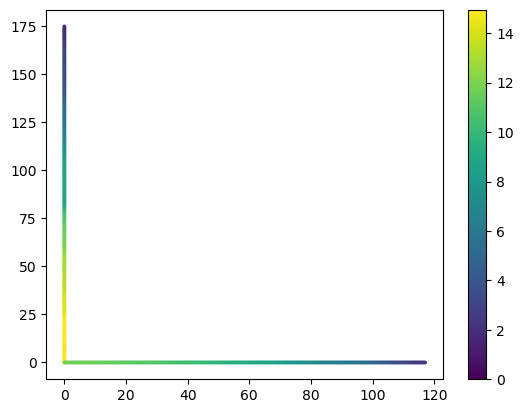

In [42]:
plt.scatter(x_data, y_data, c = top_data, vmin=0, s=3)
plt.colorbar()